# GBO Position Switching (PS) using pyspeckit

This version uses pyspeckit, but you will need the "teuben-gbt" branch, where the hacking is going on to deal with missing variables in this old data. There are also a few other bugs/software rot that were fixed, perhaps because I've also changed it to use python3.

This should reproduce Example 1 from the GBTIDL manual. The datafile you need is [here](http://safe.nrao.edu/wiki/pub/GB/Data/GBTIDLExampleAndSampleData/ngc5291.fits).


In [1]:
%matplotlib inline

import numpy as np
from astropy.io import fits
from astropy import units as u
from matplotlib import pyplot as plt
from pyspeckit.spectrum.readers import gbt


A useful stats routine so we can regress if we see the same data

In [2]:
def my_stats(label,data):
    """
    for regression
    """
    mean = data.mean()
    rms  = data.std()
    dmin = data.min()
    dmax = data.max()
    ndat = len(data)
    print("%s  %s %s %s %s %d" %  (label,repr(mean),repr(rms),repr(dmin),repr(dmax),ndat))

In [3]:
def my_loader22(fname, src, stats):
    session = gbt.GBTSession(fname)
    session.load_target(src, verbose=True)
    return session

In [4]:
fname = 'ngc5291.fits'
src   = 'NGC5291'

Loading a session is fast. It gives a quick overview, but it doesn't really load any data.

In [5]:
%%time 
session = gbt.GBTSession(fname)
print(session)

SINGLE DISH  NGC5291  131458 x 352
Observer: Jeff Mangum
Project: AGBT05B_047_01
Backend: Spectrometer
Telescope: NRAO_GBT
Bandwidth: 50000000.0
Date: 2005-06-27T02:05:58.00

       Object Name          RA        DEC           RA           DEC N(ptgs)  Exp.Time requested   n(ints)
           NGC5291  206.851994 -30.257141                                 88    859.48    859.48       176
CPU times: user 44.2 ms, sys: 0 ns, total: 44.2 ms
Wall time: 43.5 ms


In [6]:
%%time 
srcs = list(session.targets.keys())
print("Found %s" % srcs)
print("Using %s" % src)

Found ['NGC5291']
Using NGC5291
CPU times: user 259 µs, sys: 28 µs, total: 287 µs
Wall time: 216 µs


Load all blocks, as defined by a uniq (sampler,nod,....) tuplet

For GBT sampler is typically polarization (XX and YY) and multi-beam pointing

Loading all blocks, at least the way it's done in pyspeckit, can be VERY VERY slow. clearly needs a different approach.

In [7]:
%%time
print("")
print("NOTE: This command can take a while: load_target('%s')" % src)
print("")
session.load_target(src, verbose=True)
print(fname)


NOTE: This command can take a while: load_target('NGC5291')

Number of individual scans for Object NGC5291: 352
Number of spectra for sampler A13, nod 1, calON: 44
resolution 1525.88  maxdiff -1
Number of spectra for sampler A13, nod 1, calOFF: 44
resolution 1525.88  maxdiff -1
Number of spectra for sampler A13, nod 2, calON: 44
resolution 1525.88  maxdiff -1
Number of spectra for sampler A13, nod 2, calOFF: 44
resolution 1525.88  maxdiff -1
Number of spectra for sampler A9, nod 1, calON: 44
resolution 1525.88  maxdiff -1
Number of spectra for sampler A9, nod 1, calOFF: 44
resolution 1525.88  maxdiff -1
Number of spectra for sampler A9, nod 2, calON: 44
resolution 1525.88  maxdiff -1
Number of spectra for sampler A9, nod 2, calOFF: 44
resolution 1525.88  maxdiff -1
ngc5291.fits
CPU times: user 19.4 s, sys: 420 ms, total: 19.8 s
Wall time: 14.9 s


The dimensionality of the spectral data block can be written as DATA(cal[2], int[11], sampler[2], proc[2], scan[4]), with the first dimension running the fastest.       

In [8]:
%%time 
target = session[src]
print(target)
blocks = list(target.blocks.keys())
print('Found blocks',blocks)


Object NGC5291 with 8 scan blocks and 0 'reduced' spectra
Found blocks ['A13ON1', 'A13OFF1', 'A13ON2', 'A13OFF2', 'A9ON1', 'A9OFF1', 'A9ON2', 'A9OFF2']
CPU times: user 456 µs, sys: 13 µs, total: 469 µs
Wall time: 115 µs


In [9]:
nint = 0
sp0 = target.blocks[blocks[0]]
nint = len(sp0)
print("Found %d spectra in one block" % nint)

Found 44 spectra in one block


In [10]:
sp = sp0[0]
stats = sp.stats()
print(stats)

{'npts': 32768, 'std': 0.5423842316023293, 'mean': 1.1333784203702066, 'median': 1.102445363998413, 'min': 0.01712648756802082, 'max': 72.24849700927734}


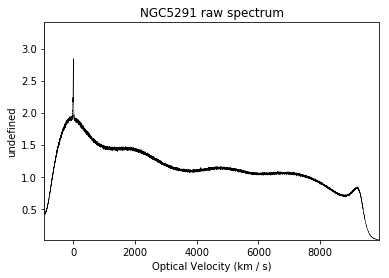

In [11]:
sp.xarr.convert_to_unit('km/s')
sp.plotter()
sp.plotter.label(verbose_label=True, title='NGC5291 raw spectrum')

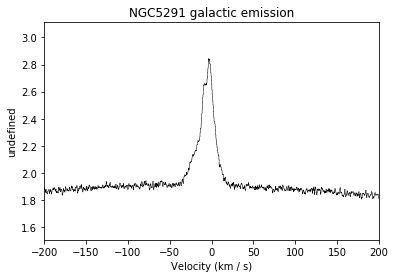

In [12]:
sp.plotter(xmin=-200, xmax=200, title='NGC5291 galactic emission')

In [13]:
target.reduce("ps",verbose=True)
print(target)

REDUCE: beams= [1]
['A13', 'A9']
Nod Pair A13 (feed 1) has tsys1=19.841090 tsys2=19.515345
Nod Pair A9 (feed 1) has tsys1=20.028388 tsys2=19.667986
Object NGC5291 with 8 scan blocks and 2 'reduced' spectra
A13
A9


{'npts': 4573, 'std': 0.022053965878821403, 'mean': 0.27083827258109755, 'median': 0.27048905294933845, 'min': 0.18294566992065173, 'max': 0.35109388639600747}
{'npts': 4573, 'std': 0.022501133904958764, 'mean': 0.3232654535036684, 'median': 0.32354660892324544, 'min': 0.24858948665716019, 'max': 0.40233764622205487}


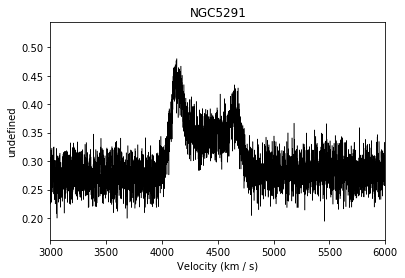

In [14]:
spol = target.reduced_scans
sp1 = spol['A13']   # YY
sp2 = spol['A9']    # XX
sp1.xarr.convert_to_unit('km/s')
sp2.xarr.convert_to_unit('km/s')
sp1.plotter()
sp1.plotter(xmin=3000,xmax=6000)
print(sp1.stats(statrange=(2000,3500)))
print(sp2.stats(statrange=(2000,3500)))

{'npts': 4573, 'std': 0.015865227200462524, 'mean': 0.297051863042383, 'median': 0.2966849625014419, 'min': 0.24276550127843746, 'max': 0.35313035830954154}


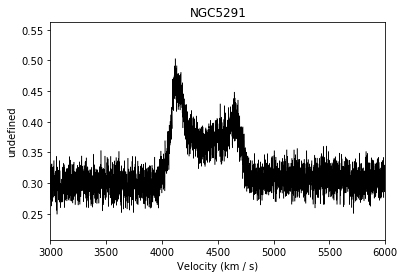

In [15]:
sp = sp2 
sp.data = (sp1.data + sp2.data)/2.0
sp.xarr.convert_to_unit('km/s')
sp.plotter()
sp.plotter(xmin=3000,xmax=6000)
print(sp.stats(statrange=(2000,3500)))
# note that pyspeckit cannot do the GBTIDL preferred way of averaging
# the raw spectra and then do (sig-ref)/ref.

GBTIDL:

     all         0.29499     0.015594   0.24217    0.35120     
     plnum=0     0.26889     0.021646   0.18349    0.35730
     plnum=1     0.32124     0.022386   0.24074    0.40275
   